### Monocular Depth Estimation Calibration Notebook

As you can read about in this github issue: https://github.com/isl-org/MiDaS/issues/37, the output of the network is actually an inverse relative depth. The relationship is as follows:
$$\frac{1}{\text{true depth}} = \alpha \times \text{output} + \beta$$

The purpose of calibration is to learn $\alpha$ and $\beta$, so that we can then find the true depth of an unknown obstacle:
$$\text{true depth} = \frac{1}{\alpha \times \text{output} + \beta}$$

One inconvenient reality is that $\alpha$ and $\beta$ are prone to change from frame to frame. Therefore, one approach is to have _two_ landmark images (of a known distance from the drone) to calibrate for each frame. As the drone moves, this known distance would have to be updated using odometry (for example, optical flow). If you choose to use this approach, you can expect two landmarks (available during practice) for your final runs. We will provide example landmarks; you may also suggest your own landmarks if you find something that works well in your practice. In this notebook, we took the drone and moved it through a course with known landmark positions and known obstacle positions. Usng the landmarks, we could estimate the obstacle positions using the depth. We could then asses the accuracy of the depth estimation. The hybrid and large models have quite good accuracy, but take 3 and 11 seconds (respectively) to run on a laptop (yours may be faster). There is potential GPU access for teams that would like to run their real-time script from a desktop in G105 - please inquire ASAP if interested.

The purpose of this notebook is to demonstrate some of the steps you might use to calibrate monocular depth estimation. We recommend trying this out _without flying the drone_, to get used to the depth estimation process, before attempting to implement it in-flight.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import time
import torch

The next few cells follow the [instructions](https://pytorch.org/hub/intelisl_midas_v2/) here. Reference them to install any dependencies (e.g. `pip install timm`). You can also check their github: https://github.com/isl-org/MiDaS/.


The following cell can be used to save images from a camera feed while the drone is not flying. This is useful for calibration purposes.

**Note:** This notebook was run on a Windows Laptop. Your file paths may be different on Linux and Mac (possibly the directions of `\` vs `/`), something to keep in mind.

In [ ]:
saveImage = True
path = "saved_images/samples" # desired folder name here
pos = "000_" # for calibration purposes, distance of the drone (for file naming purposes)

if saveImage and not os.path.exists(path):
    print("Making image directory: ",path)
    os.makedirs(path)
    print(path, " directory is created.")

cap = cv2.VideoCapture(1) # may have to change the camera # here as in previous assignments!

for i in range(2): # we find that it helps to try twice...
    # Capture frame-by-frame
    ret, frame = cap.read()
if saveImage:
    cv2.imwrite(str(path)+'/'+pos+time.strftime("%Y%m%d-%H%M%S")+'.jpg',frame)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

Now, we choose our MiDaS model type. As mentioned in the readme, the smaller models are less accurate but run faster.

In [2]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in C:\Users\nsimo/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\nsimo/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

In [4]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\nsimo/.cache\torch\hub\intel-isl_MiDaS_master


Next, we write a helper function that returns an array (`output`), which is the inverse relative depth estimate produced by the network. Yes, the network actually estimates _inverse_ relative depth; that is - farther objects have lower values. This estimate can be related to abslolute depth (in inches, meters, etc.) through the equations mentioned at the top of this notebook. You can read more here: https://github.com/isl-org/MiDaS/issues/37.

In [5]:
def get_depth(input_batch):
    start_time = time.time()
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    print('time: ',time.time()-start_time)
    return output

Now, we can read-in our sample images (saved earlier), get their depth estimates, and save them to a different folder. We're also saving the outputs as a .npy file for later use. We're also printing the time of inference, which is useful in determining how the performance will affect the Crazyflie.

000_20221128-184028.jpg
time:  0.29623937606811523
output shape:  (480, 640)


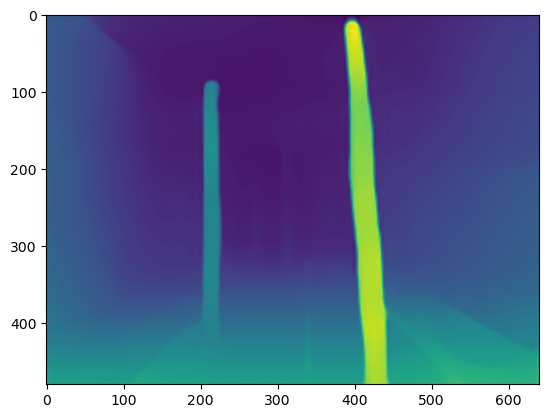

010_20221128-183953.jpg
time:  0.21741223335266113
output shape:  (480, 640)


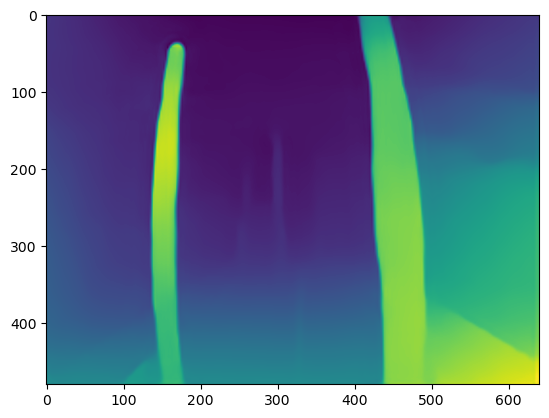

020_20221128-184125.jpg
time:  0.31016969680786133
output shape:  (480, 640)


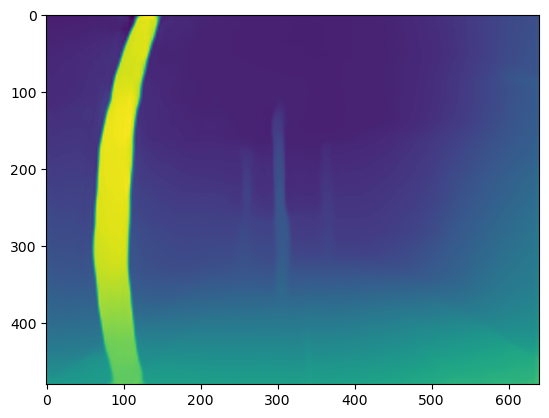

030_20221128-184316.jpg
time:  0.24234914779663086
output shape:  (480, 640)


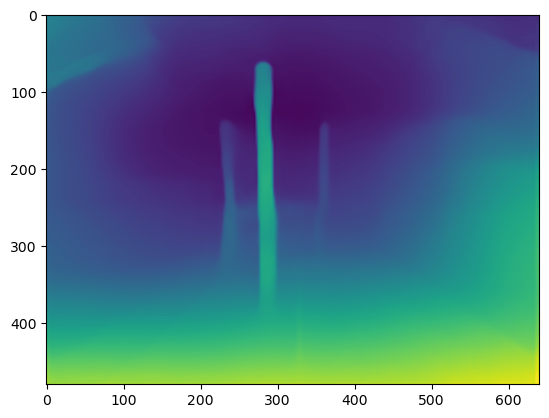

040_20221128-184653.jpg
time:  0.3181476593017578
output shape:  (480, 640)


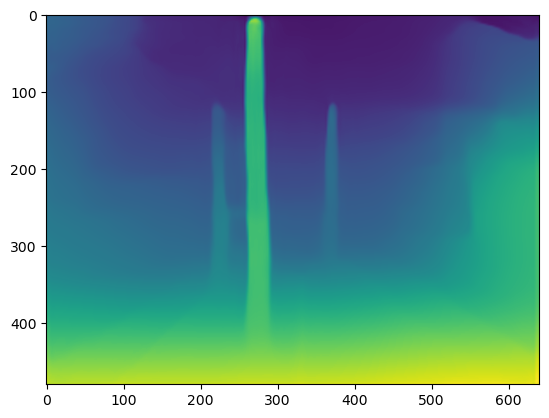

050_20221128-184725.jpg
time:  0.19352245330810547
output shape:  (480, 640)


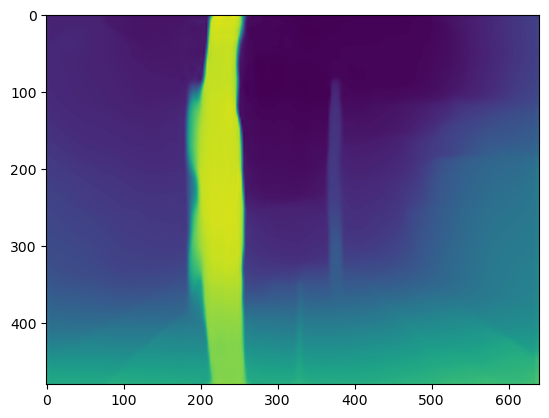

060_20221128-184817.jpg
time:  0.486696720123291
output shape:  (480, 640)


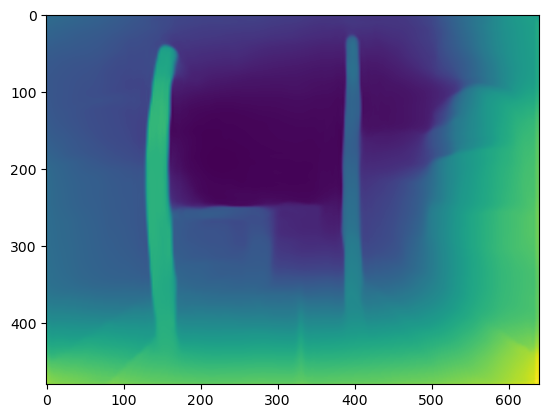

070_20221128-184905.jpg
time:  0.15658068656921387
output shape:  (480, 640)


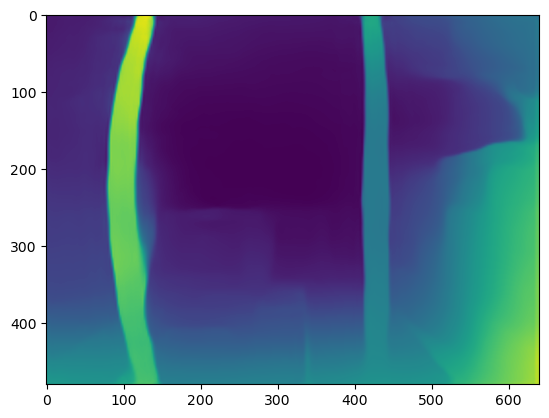

080_20221128-184950.jpg
time:  0.18251371383666992
output shape:  (480, 640)


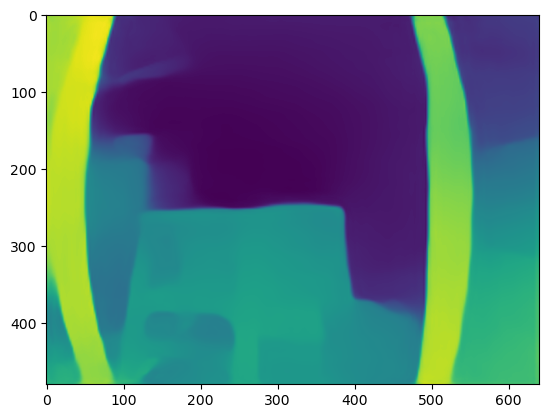

090_20221128-185058.jpg
time:  0.27724599838256836
output shape:  (480, 640)


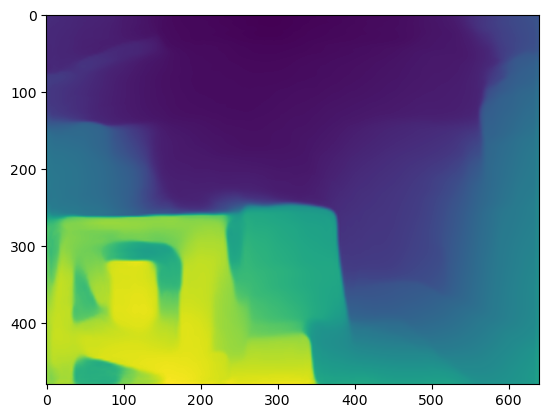

100_20221128-185200.jpg
time:  0.4577667713165283
output shape:  (480, 640)


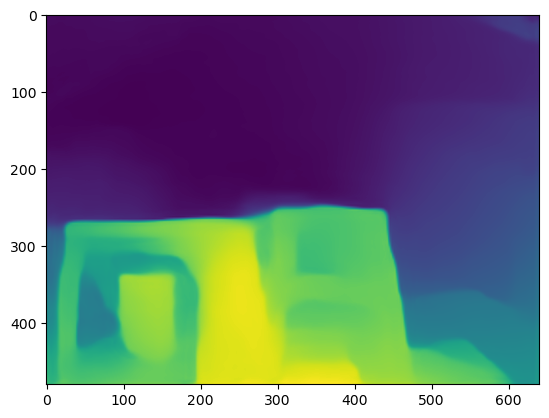

In [6]:
dir_list = os.listdir("saved_images/samples")
for file in dir_list: #first only
    print(file)
    img = cv2.imread("saved_images/samples/"+file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_batch = transform(img).to(device)
    output = get_depth(input_batch)
    print("output shape: ",np.shape(output))
    
    plt.imshow(output)
    plt.show()

    plt.imsave('saved_images/sample_depths/'+file,output)
    filename_no_jpg = file.split('.')[0]
    np.save('saved_images/sample_depths/'+filename_no_jpg,output)

As mentioned previously, the calibration step depends on knowing the distances from two landmarks. You can detect landmarks as objects with a unique color. Using HSV (another color representation), you can locate these landmark in your raw image, and then retrieve their depths from your depth image.

000_20221128-184028.jpg


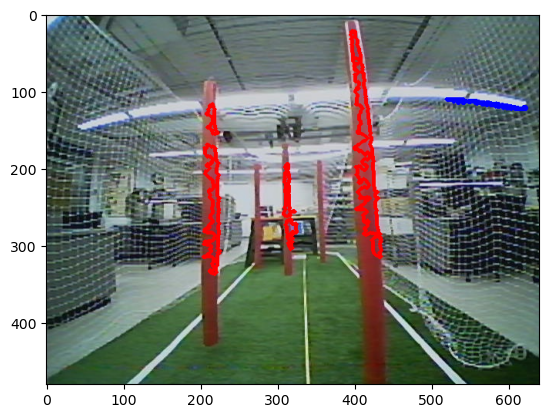

010_20221128-183953.jpg


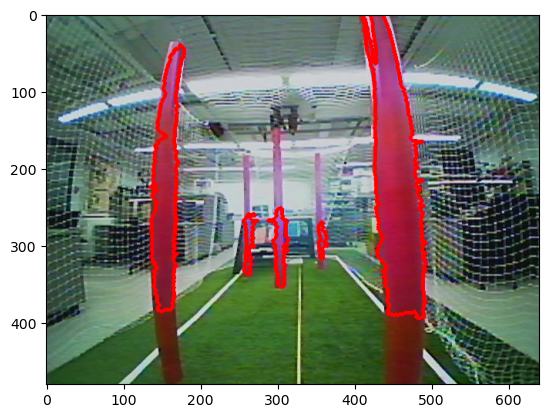

020_20221128-184125.jpg


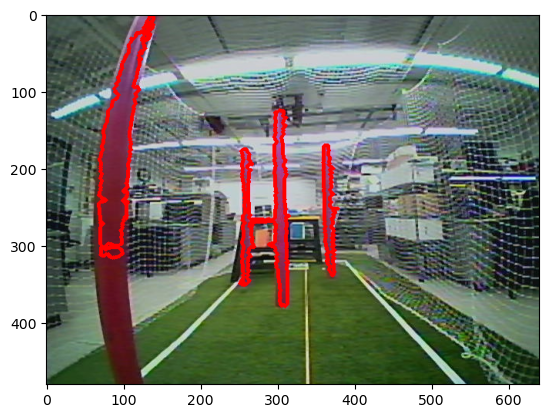

030_20221128-184316.jpg


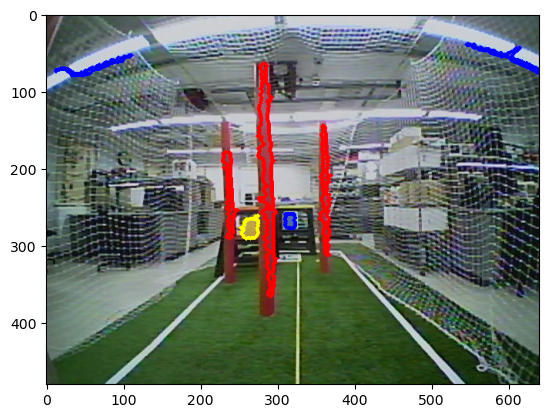

040_20221128-184653.jpg


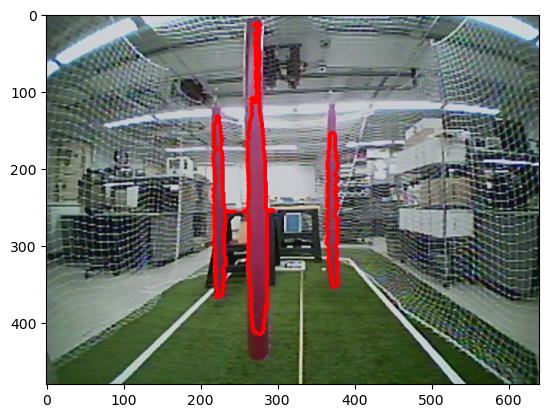

050_20221128-184725.jpg


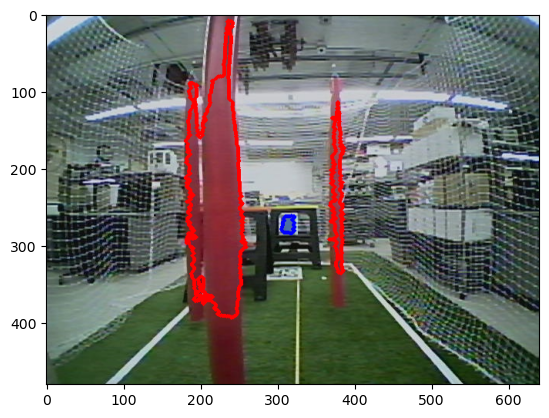

060_20221128-184817.jpg


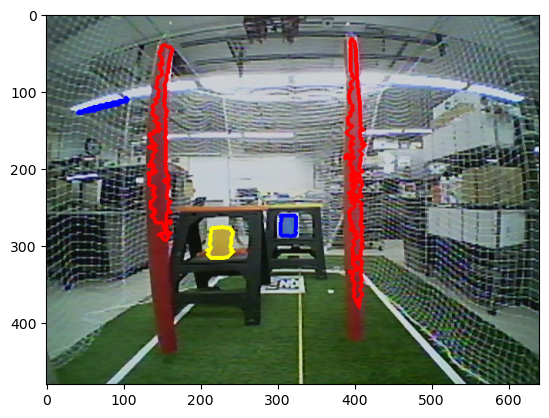

070_20221128-184905.jpg


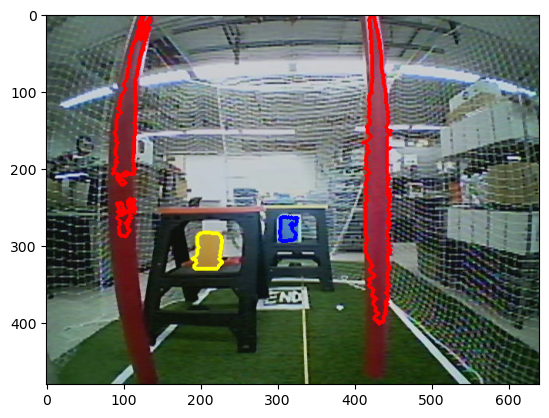

080_20221128-184950.jpg


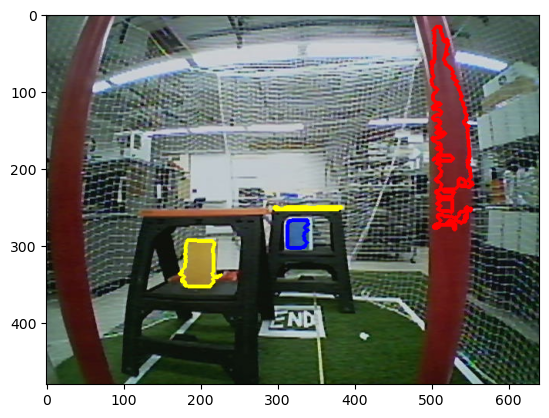

090_20221128-185058.jpg


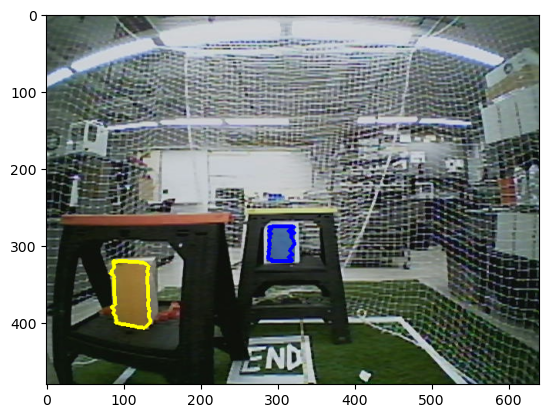

100_20221128-185200.jpg


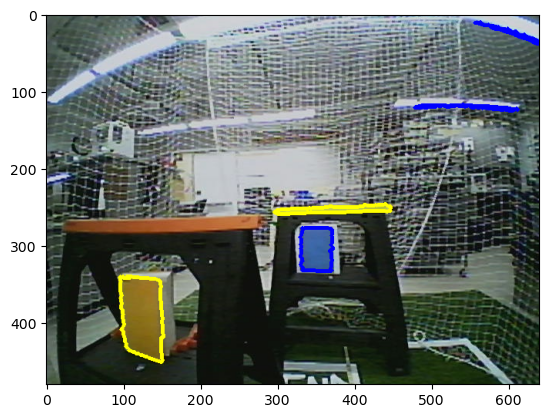

In [8]:
dir_list = os.listdir("saved_images/sample_depths")
for file in dir_list:
    if file.endswith('.jpg'): # since we have .npy files, too - but only want to iterate over the .jpgs
        print(file)
        frame_bgr = cv2.imread("saved_images/samples/"+file) # note: by default, cv2 uses BGR instead of RGB
        hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)

        #Yellow Mask (for our yellow landmark)
        lower_yellow = np.array([15,100,100])
        upper_yellow = np.array([35,255,255])
        mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
        frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        res_yellow = cv2.bitwise_and(frame,frame, mask= mask_yellow)

        #Blue Mask (for our blue landmark)
        lower_blue = np.array([105,100,100])
        upper_blue = np.array([120,200,200])
        mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
        frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        res_blue = cv2.bitwise_and(frame,frame, mask= mask_blue)
    #     plt.imshow(res_blue) # these optional cells show the residual blue mask detected - a good check!
    #     plt.show()

        #Red Mask (for our red landmark)
        lower_red = np.array([120,100,100])
        upper_red = np.array([180,255,255])
        mask_red = cv2.inRange(hsv, lower_red, upper_red)
        frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        res_red = cv2.bitwise_and(frame,frame, mask= mask_red)
    #     plt.imshow(res_red)
    #     plt.show()

        #Plotting each contour
        red_contours, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in red_contours:
            if cv2.contourArea(contour) > 200:
                cv2.drawContours(frame, contour, -1, (255, 0, 0), 3)
        blue_contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in blue_contours:
            if cv2.contourArea(contour) > 200:
                cv2.drawContours(frame, contour, -1, (0, 0, 255), 3)
        yellow_contours, _ = cv2.findContours(mask_yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in yellow_contours:
            if cv2.contourArea(contour) > 200:
                cv2.drawContours(frame, contour, -1, (255, 255, 0), 3)
        plt.imsave('saved_images/sample_colormasks/'+file,frame)
        plt.imshow(frame)
        plt.show()

In this next cell, we find the depth at the center of each contour (landmark and obstacles). A better way to do this might be finding the average depth of the entire area within the contour; the center seems to work (for now).

file:  000_20221128-184028.jpg
000_20221128-184028.jpg
blue contour area:  263.0


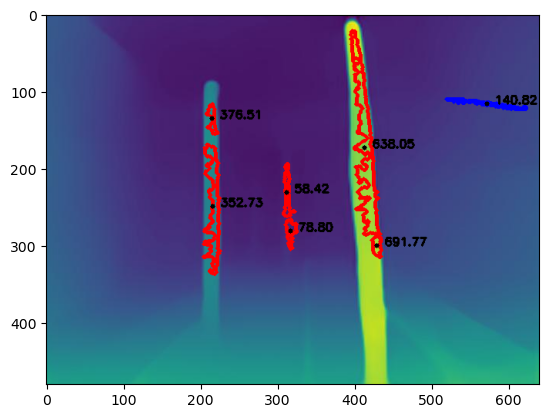

file:  010_20221128-183953.jpg
010_20221128-183953.jpg


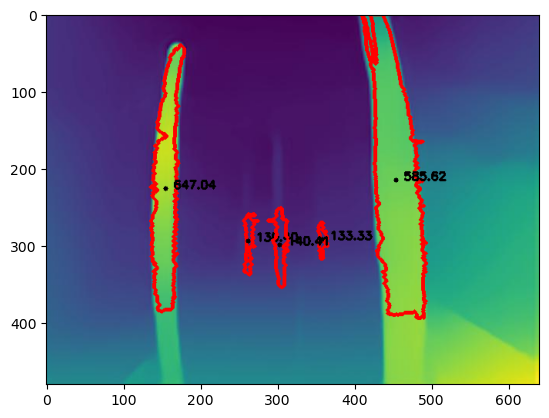

file:  020_20221128-184125.jpg
020_20221128-184125.jpg


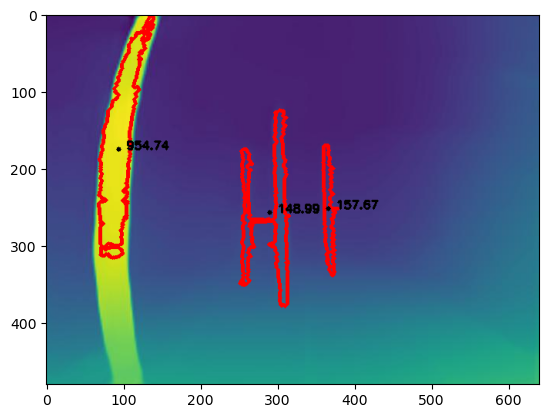

file:  030_20221128-184316.jpg
030_20221128-184316.jpg
blue contour area:  216.0
blue contour area:  292.5
blue contour area:  359.0
yellow contour area:  445.5


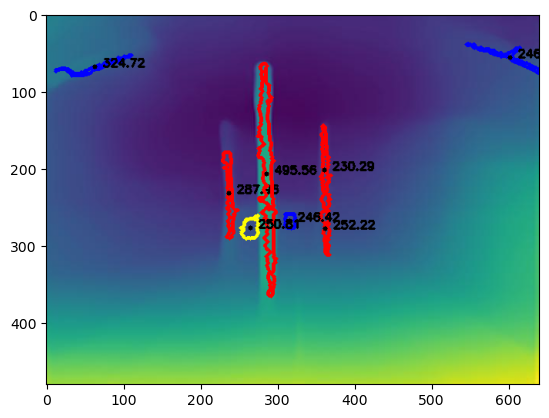

file:  040_20221128-184653.jpg
040_20221128-184653.jpg


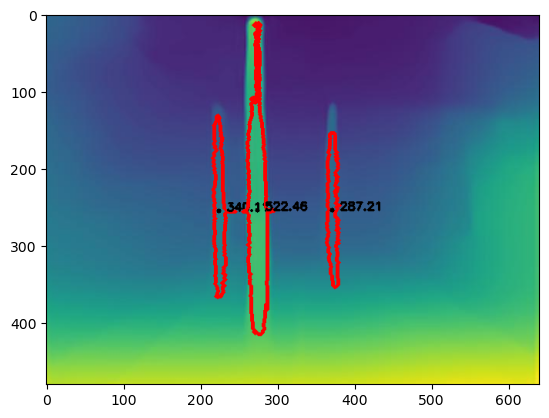

file:  050_20221128-184725.jpg
050_20221128-184725.jpg
blue contour area:  292.5


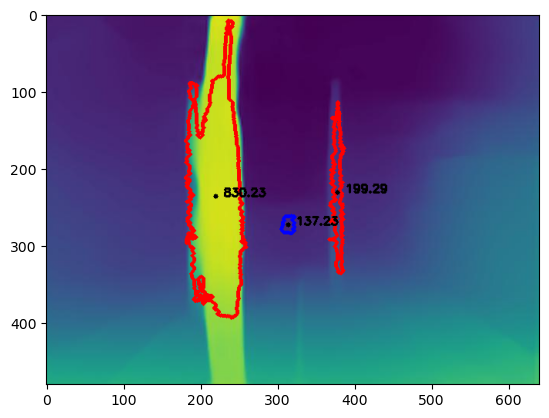

file:  060_20221128-184817.jpg
060_20221128-184817.jpg
blue contour area:  510.5
blue contour area:  209.5
yellow contour area:  1069.5


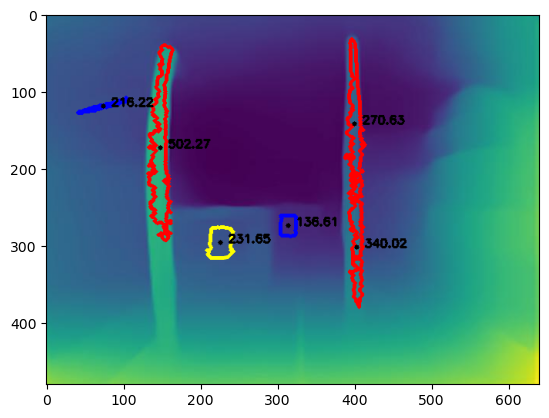

file:  070_20221128-184905.jpg
070_20221128-184905.jpg
blue contour area:  548.0
yellow contour area:  1430.0


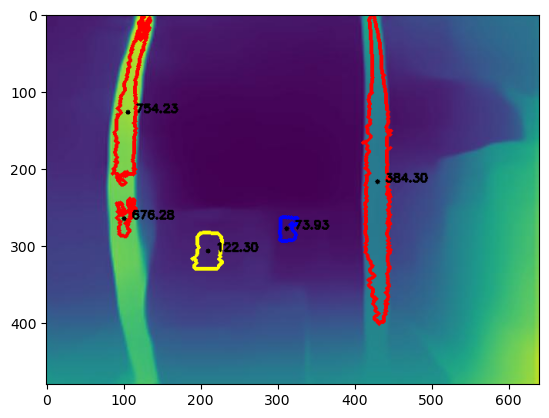

file:  080_20221128-184950.jpg
080_20221128-184950.jpg
blue contour area:  833.0
yellow contour area:  2204.0


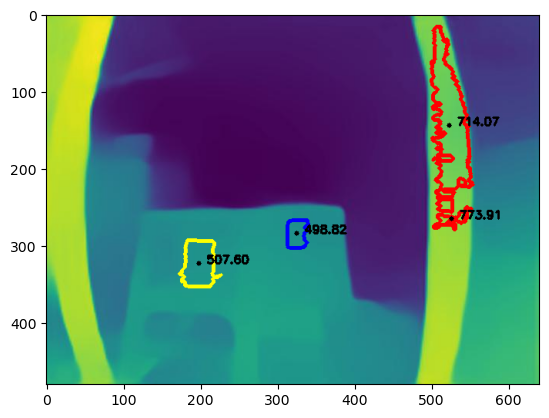

file:  090_20221128-185058.jpg
090_20221128-185058.jpg
blue contour area:  1283.0
yellow contour area:  3649.5


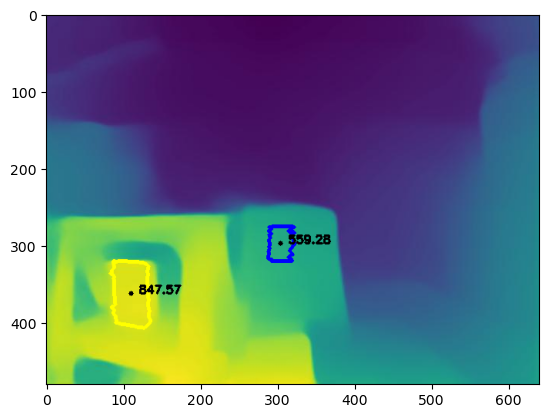

file:  100_20221128-185200.jpg
100_20221128-185200.jpg
blue contour area:  2169.5
blue contour area:  244.0
blue contour area:  215.0
yellow contour area:  5048.5
yellow contour area:  974.0


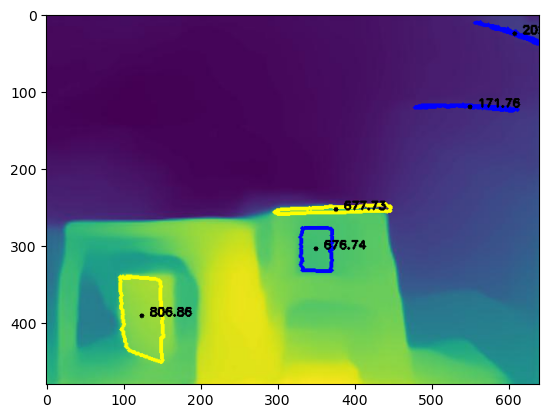

In [9]:
dir_list = os.listdir("saved_images/sample_depths")
for file in dir_list:
    if file.endswith('.jpg'):
        print("file: ",file)
        
        filename_no_jpg = file.split('.')[0]
        print(file)
        output = np.load('saved_images/sample_depths/'+filename_no_jpg+'.npy')
        
        frame_bgr = cv2.imread("saved_images/samples/"+file)
        hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)

        #Yellow Mask
        lower_yellow = np.array([15,100,100])
        upper_yellow = np.array([35,255,255])
        mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
        frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        res_yellow = cv2.bitwise_and(frame,frame, mask= mask_yellow)

        #Blue Mask
        lower_blue = np.array([105,100,100])
        upper_blue = np.array([120,200,200])
        mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
        frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        res_blue = cv2.bitwise_and(frame,frame, mask= mask_blue)

        #Red Mask
        lower_red = np.array([120,100,100])
        upper_red = np.array([180,255,255])
        mask_red = cv2.inRange(hsv, lower_red, upper_red)
        frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
        res_red = cv2.bitwise_and(frame,frame, mask= mask_red)

        depth_bgr = cv2.imread("saved_images/sample_depths/"+file)
        depth_rgb = cv2.cvtColor(depth_bgr, cv2.COLOR_BGR2RGB)

        #Plotting each contour
        red_contours, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in red_contours:
            if cv2.contourArea(contour) > 200:
                cv2.drawContours(depth_rgb, contour, -1, (255, 0, 0), 3)
                #this finds the center of each contour
                M = cv2.moments(contour)
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                # draw the contour and center of the shape on the image
                cv2.circle(depth_rgb, (cX, cY), 3, (0, 0, 0), -1)
                cv2.putText(depth_rgb, "{:.2f}".format(output[cY,cX]), (cX+10, cY),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        blue_contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in blue_contours:
            if cv2.contourArea(contour) > 200:
                print('blue contour area: ',cv2.contourArea(contour))
                cv2.drawContours(depth_rgb, contour, -1, (0, 0, 255), 3)
                M = cv2.moments(contour)
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                # draw the contour and center of the shape on the image
                cv2.circle(depth_rgb, (cX, cY), 3, (0, 0, 0), -1)
                cv2.putText(depth_rgb, "{:.2f}".format(output[cY,cX]), (cX+10, cY),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        yellow_contours, _ = cv2.findContours(mask_yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        for contour in yellow_contours:
            if cv2.contourArea(contour) > 400:
                print('yellow contour area: ',cv2.contourArea(contour))
                cv2.drawContours(depth_rgb, contour, -1, (255, 255, 0), 3)
                M = cv2.moments(contour)
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                # draw the contour and center of the shape on the image
                cv2.circle(depth_rgb, (cX, cY), 3, (0, 0, 0), -1)
                cv2.putText(depth_rgb, "{:.2f}".format(output[cY,cX]), (cX+10, cY),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
        plt.imsave('saved_images/sample_depthmasks_text/'+file,depth_rgb)
        plt.imshow(depth_rgb)
        plt.show()


Every good calibration needs the ground truth measurements. Using a ruler, we measured the course geometry. We could then compare the drone's perceived distance to the actual distance. In the figure below, the obstacles are labeled in red, the yellow and blue landmark positions are shown as circles, and the drone's trajectory and location of each figure are shown as a dotted line with an X.

C:\Users\nsimo\Anaconda3\envs\mae345\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


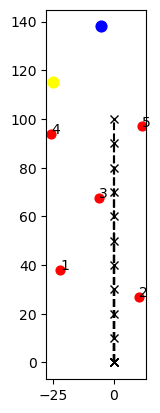

In [10]:
# Obstacle, Landmark definitions
obstacles = [[-22,38],[10.5,27],[-6,67.5],[-25.75,94],[11.5,97]] # inches
start = np.array([0,0])
lmark_yellow = np.array([-25,115])
lmark_blue = np.array([-5,138])
fig, ax = plt.subplots(1, 1)
for count, obstacle in enumerate(obstacles):
    ax.scatter(obstacle[0], obstacle[1], s=40, c = '#FF0000')
    plt.text(obstacle[0], obstacle[1],str(count+1))
ax.scatter(lmark_yellow[0], lmark_yellow[1], s=60, c = '#FFFF00')
ax.scatter(lmark_blue[0], lmark_blue[1], s=60, c = '#0000FF')
for i in range(11):
    plt.plot([0,0],[0,10*i],'--xk')
ax.set_aspect('equal', 'box')
fig.show()

Here, we manually transcribed the calculated depths of each contour in order to fit the scaling and offset parameters. (Calibration at each frame.) This was just to determine the accuracy of our model. One challenge is that the landmarks are not spotted for each image; in fact, of the 11 images, only 4 contain both landmarks and obstacles.

The $\alpha$ and $\beta$ parameters are fit through `np.polyfit`.

In [11]:
# -1 indicates that the landmark was not spotted
# six valid calibration stations
#SMALL MODEL SIZE
yellow = [-1,-1,-1,250.81,-1,-1    ,231.65,122.30,507.60,847.57,806.86]
blue =   [-1,-1,-1,246.42,-1,137.23,136.61,73.93,498.82,559.28,676.74]

# # HYBRID MODEL SIZE
# yellow = [-1,-1,-1,314.40,-1,-1,     658.58,796.82,896.98,1523.78,1273.15]
# blue =   [-1,-1,-1,237.17,-1, 329.02,389.43,370.14,450.05,439.01,802.63]


# # LARGE MODEL SIZE
# yellow = [-1,-1,-1,5.77,-1,-1,   8.83,8.45,7.43,21.33,23.82]
# blue =   [-1,-1,-1,3.11,-1, 3.05,5.05,4.33,5.98,17.18,18.13]

poly_list = []
index_list = [] # indices of the images that contained both landmarks
true_yellow_dist_list = []
true_blue_dist_list = []

for i in range(len(yellow)):
    if yellow[i] > 0 and blue[i] > 0:
        #print('calibration point: index ',i,', drone y (in):',i*10)
        true_yellow_dist = np.linalg.norm(lmark_yellow-np.array([0,i*10]))
        true_blue_dist = np.linalg.norm(lmark_blue-np.array([0,i*10]))
        #print('true_yellow_dist (in): ',int(true_yellow_dist))
        #print('true_blue_dist (in): ',int(true_blue_dist))
        ys = 1/np.array([true_yellow_dist, true_blue_dist])
        xs = np.array([yellow[i],blue[i]])
        
        p = np.polyfit(xs,ys,1) # calculate the line for calibration
        index_list.append(i)
        poly_list.append(p)
        true_yellow_dist_list.append(true_yellow_dist)
        true_blue_dist_list.append(true_blue_dist)


We now have polynomial fits (i.e. linear fits with $\alpha$ and $\beta$ parameters) for each frame that contained both landmarks! Woohoo! Let's iterate again through only the images with the landmarks, plotting the relative inverse depth (black) and the estimated true depth (white). As mentioned, the current depth is coming from the center of the contour. A better approach might be to average the estimated depths over the entire contour area. One approach to do this is to createa bounding box over each contour. This bounding box and the average estimated depth inside is shown on the figures in pink as well. As you can see, the fish-eye lens causes some obstacles to bend - which doesn't fit the bounding box very well. We welcome any better approaches to this challenge!

030_20221128-184316.jpg
drone_pos (in):  30
dist_from_obs:  37.97696670351649
dist_from_obs:  68.98595871624892
dist_from_obs:  67.97977640445723
yellow contour area:  445.5
yellow_depth_est:  88.58422819869763
true_blue_dist:  108.11567878897121
true_yellow_dist:  88.60022573334675


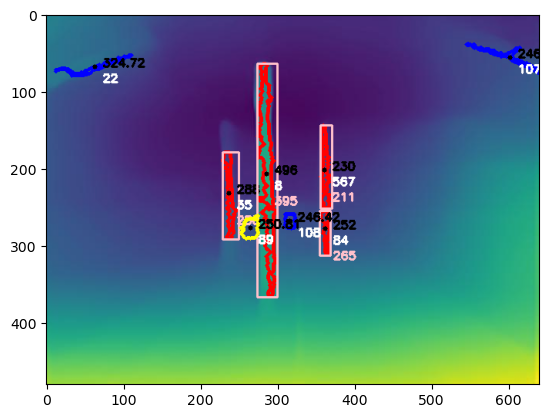

060_20221128-184817.jpg
drone_pos (in):  60
dist_from_obs:  42.65046893059911
dist_from_obs:  38.74596753211875
yellow contour area:  1069.5
yellow_depth_est:  60.41486739563492
true_blue_dist:  78.16009211867653
true_yellow_dist:  60.41522986797286


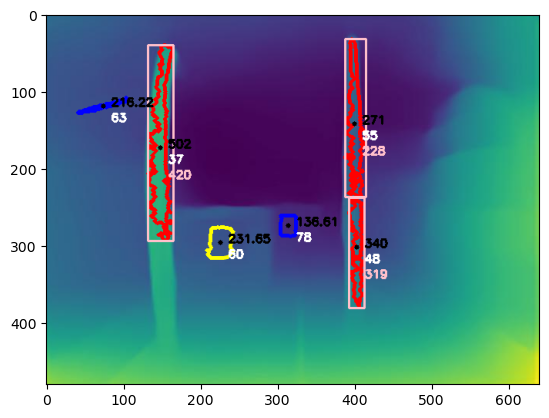

070_20221128-184905.jpg
drone_pos (in):  70
dist_from_obs:  35.20031960082181
dist_from_obs:  29.34706118165838
yellow contour area:  1430.0
yellow_depth_est:  51.47779978317396
true_blue_dist:  68.18357573492314
true_yellow_dist:  51.478150704935004


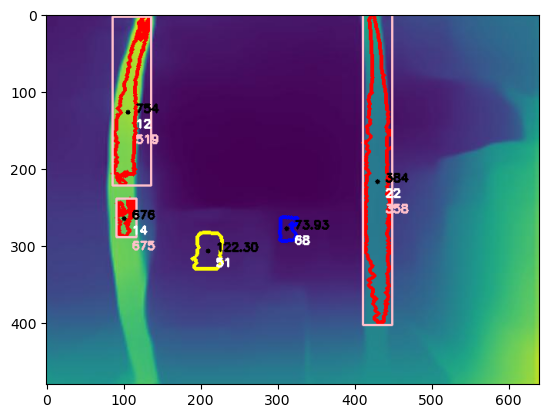

080_20221128-184950.jpg
drone_pos (in):  80
dist_from_obs:  29.309767996352342
dist_from_obs:  20.524375751773793
yellow contour area:  2204.0
yellow_depth_est:  43.0096273998318
true_blue_dist:  58.215118311311535
true_yellow_dist:  43.01162633521314


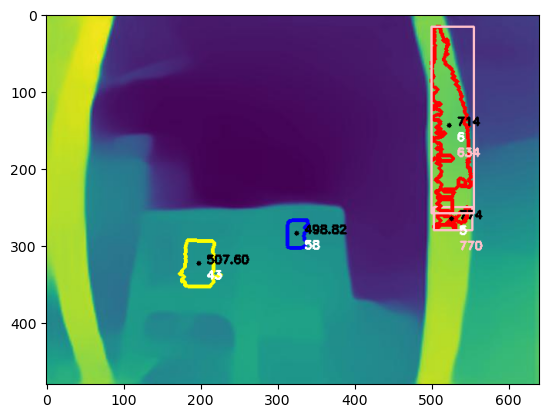

090_20221128-185058.jpg
drone_pos (in):  90
yellow contour area:  3649.5
yellow_depth_est:  35.355304793512914
true_blue_dist:  48.25971404805462
true_yellow_dist:  35.35533905932738


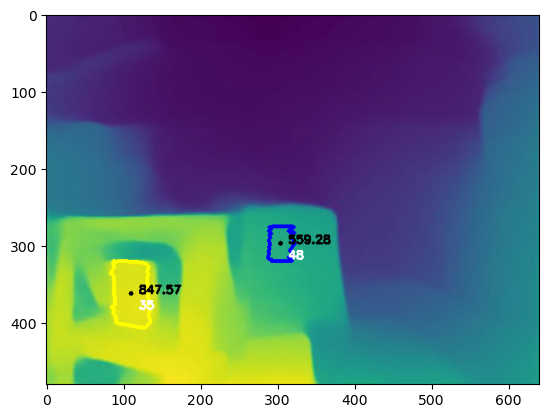

100_20221128-185200.jpg
drone_pos (in):  100
yellow contour area:  5048.5
yellow_depth_est:  29.154953363289717
yellow contour area:  974.0
yellow_depth_est:  38.236409065359716
true_blue_dist:  38.3275357934736
true_yellow_dist:  29.154759474226502


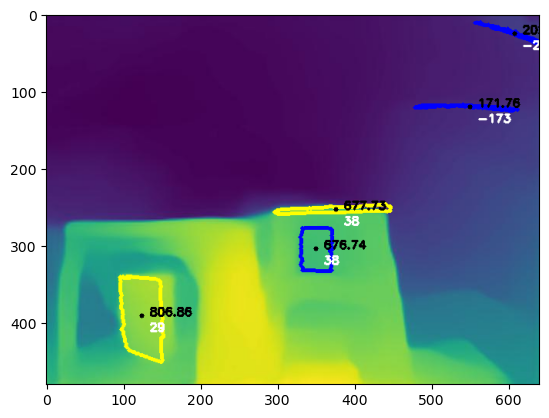

In [12]:
dir_list = os.listdir("saved_images/sample_depths")
jpg_list = []
for file in dir_list:
    if file.endswith('.jpg'):
        jpg_list.append(file)
for ix, pic_ix in enumerate(index_list):
    file = jpg_list[pic_ix]
    filename_no_jpg = file.split('.')[0]
    print(file)
    output = np.load('saved_images/sample_depths/'+filename_no_jpg+'.npy')

    frame_bgr = cv2.imread("saved_images/samples/"+file)
    hsv = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2HSV)

    #Yellow Mask
    lower_yellow = np.array([15,100,100])
    upper_yellow = np.array([35,255,255])
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
    frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    res_yellow = cv2.bitwise_and(frame,frame, mask= mask_yellow)

    #Blue Mask
    lower_blue = np.array([105,100,100])
    upper_blue = np.array([120,200,200])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    res_blue = cv2.bitwise_and(frame,frame, mask= mask_blue)
#     plt.imshow(res_blue)
#     plt.show()

    #Red Mask
    lower_red = np.array([120,100,100])
    upper_red = np.array([180,255,255])
    mask_red = cv2.inRange(hsv, lower_red, upper_red)
    frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    res_red = cv2.bitwise_and(frame,frame, mask= mask_red)
#     plt.imshow(res_red)
#     plt.show()

    depth_bgr = cv2.imread("saved_images/sample_depths/"+file)
    depth_rgb = cv2.cvtColor(depth_bgr, cv2.COLOR_BGR2RGB)

    #Plotting each contour
    red_contours, _ = cv2.findContours(mask_red, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in red_contours:
        if cv2.contourArea(contour) > 200:
            cv2.drawContours(depth_rgb, contour, -1, (255, 0, 0), 3)
            
            # experimenting with a bounding box
            x,yR,w,h = cv2.boundingRect(contour)
            cv2.rectangle(depth_rgb,(x,yR),(x+w,yR+h),(255,192,203),2)
            
            M = cv2.moments(contour)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            # draw the contour and center of the shape on the image
            cv2.circle(depth_rgb, (cX, cY), 3, (0, 0, 0), -1)
            cv2.putText(depth_rgb, str(round(output[cY,cX])), (cX+10, cY),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            
            # calculate distance from obstacles
            p = poly_list[ix]
            y = np.polyval(p, output[cY,cX])
            depth_est = 1/y
            
            cv2.putText(depth_rgb, str(round(depth_est)), (cX+10, cY+20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            
            box_mean = np.mean(output[yR:yR+h,x:x+w], axis=(0, 1))
            cv2.putText(depth_rgb, str(round(box_mean)), (cX+10, cY+40),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,192,203), 2)  
            
    # print the true distance from obstacles
    drone_pos = pic_ix*10
    print('drone_pos (in): ',drone_pos)
    for obstacle in obstacles:
        if obstacle[1] > drone_pos+10: # if the obstacle is in front of the drone (by 5 in to account for camera FOV)
            dist_from_obs = np.linalg.norm(np.array([obstacle[0],obstacle[1]])-np.array([0,drone_pos]))
            print('dist_from_obs: ',dist_from_obs)

    
    blue_contours, _ = cv2.findContours(mask_blue, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in blue_contours:
        if cv2.contourArea(contour) > 200:
            cv2.drawContours(depth_rgb, contour, -1, (0, 0, 255), 3)
            M = cv2.moments(contour)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            # draw the contour and center of the shape on the image
            cv2.circle(depth_rgb, (cX, cY), 3, (0, 0, 0), -1)
            cv2.putText(depth_rgb, "{:.2f}".format(output[cY,cX]), (cX+10, cY),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            
            # calculate distance from obstacles
            p = poly_list[ix]
            y = np.polyval(p, output[cY,cX])
            depth_est = 1/y
            
            cv2.putText(depth_rgb, str(round(depth_est)), (cX+10, cY+20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    yellow_contours, _ = cv2.findContours(mask_yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in yellow_contours:
        if cv2.contourArea(contour) > 400:
            print('yellow contour area: ',cv2.contourArea(contour))
            cv2.drawContours(depth_rgb, contour, -1, (255, 255, 0), 3)
            M = cv2.moments(contour)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            # draw the contour and center of the shape on the image
            cv2.circle(depth_rgb, (cX, cY), 3, (0, 0, 0), -1)
            cv2.putText(depth_rgb, "{:.2f}".format(output[cY,cX]), (cX+10, cY),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
            
            # calculate distance from obstacles
            p = poly_list[ix]
            y = np.polyval(p, output[cY,cX])
            depth_est = 1/y
            print('yellow_depth_est: ',depth_est)
            cv2.putText(depth_rgb, str(round(depth_est)), (cX+10, cY+20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    print('true_blue_dist: ',true_blue_dist_list[ix])
    print('true_yellow_dist: ',true_yellow_dist_list[ix])

    plt.imsave('saved_images/sample_depthestmasks_text/'+file,depth_rgb)
    plt.imshow(depth_rgb)
    plt.show()



In the next cells, we display the errors of each network. While the depth estimates aren't perfect (especially for the small network), they are likely sufficient for obstacle avoidance. The large and hybrid models have ~10-30 cm accuracy, while the small model has ~40 cm accuracy. The accuracy seems to depend on the visibility of the landmarks, and the ratio of the distance between landmarks and the distance of the drone to landmarks. Something to keep in mind!

In [16]:
print('model_type = "DPT_Large"')

Img1_dists = np.array([37.97696670351649,68.98595871624892,67.97977640445723])
Img2_dists = np.array([42.65046893059911,38.74596753211875])
Img3_dists = np.array([35.20031960082181,29.34706118165838])
Img4_dists = np.array([20.524375751773793])

Img1_est = np.array([56, 79, 78])
Img2_est = np.array([48, 45])
Img3_est = np.array([36, 32])
Img4_est = np.array([12])

print("Img1 Error (in): ",Img1_dists-Img1_est)
print("Img2 Error (in): ",Img2_dists-Img2_est)
print("Img3 Error (in): ",Img3_dists-Img3_est)
print("Img4 Error (in): ",Img4_dists-Img4_est)

model_type = "DPT_Large"
Img1 Error (in):  [-18.0230333  -10.01404128 -10.0202236 ]
Img2 Error (in):  [-5.34953107 -6.25403247]
Img3 Error (in):  [-0.7996804  -2.65293882]
Img4 Error (in):  [8.52437575]


In [17]:
print('model_type = "DPT_Hybrid"')

Img1_dists = np.array([37.97696670351649,68.98595871624892,67.97977640445723])
Img2_dists = np.array([42.65046893059911,38.74596753211875])
Img3_dists = np.array([35.20031960082181,29.34706118165838])
Img4_dists = np.array([20.524375751773793])

Img1_est = np.array([36, 54, 67.5])
Img2_est = np.array([46, 39])
Img3_est = np.array([39, 35])
Img4_est = np.array([27.5])

print("Img1 Error (in): ",Img1_dists-Img1_est)
print("Img2 Error (in): ",Img2_dists-Img2_est)
print("Img3 Error (in): ",Img3_dists-Img3_est)
print("Img4 Error (in): ",Img4_dists-Img4_est)

model_type = "DPT_Hybrid"
Img1 Error (in):  [ 1.9769667  14.98595872  0.4797764 ]
Img2 Error (in):  [-3.34953107 -0.25403247]
Img3 Error (in):  [-3.7996804  -5.65293882]
Img4 Error (in):  [-6.97562425]


In [18]:
print('model_type = "MiDaS_small"')

Img1_dists = np.array([37.97696670351649,68.98595871624892,67.97977640445723])
Img2_dists = np.array([42.65046893059911,38.74596753211875])
Img3_dists = np.array([35.20031960082181,29.34706118165838])
Img4_dists = np.array([20.524375751773793])

Img1_est = np.array([8, 35, 84])
Img2_est = np.array([51, 37])
Img3_est = np.array([22, 13])
Img4_est = np.array([5.5])

print("Img1 Error (in): ",Img1_dists-Img1_est)
print("Img2 Error (in): ",Img2_dists-Img2_est)
print("Img3 Error (in): ",Img3_dists-Img3_est)
print("Img4 Error (in): ",Img4_dists-Img4_est)

model_type = "MiDaS_small"
Img1 Error (in):  [ 29.9769667   33.98595872 -16.0202236 ]
Img2 Error (in):  [-8.34953107  1.74596753]
Img3 Error (in):  [13.2003196  16.34706118]
Img4 Error (in):  [15.02437575]
